<a href="https://colab.research.google.com/github/pratikiiitb2013/EVA/blob/master/Session7/Assignment_7B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras import backend as K
import tensorflow as tf
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConv2D, Conv2D
from keras.layers import Activation, Flatten, Dense, Dropout, Input, Lambda
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.models import Model
from keras.layers.merge import concatenate

def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

Using TensorFlow backend.


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

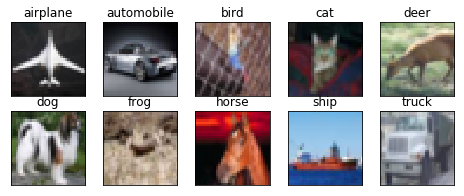

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [7]:
# Define the model

input = Input(shape=(32, 32, 3,))
x1 = SeparableConv2D(32, (5,5), border_mode='same', name='x1')(input)
x1_r = Activation('relu')(x1)
x1_bn = BatchNormalization(name='x1_bn')(x1_r)

x2 = Conv2D(32, (5,5), border_mode='same', name='x2')(x1_bn)
x2_r = Activation('relu')(x2)
x2_bn = BatchNormalization(name='x2_bn')(x2_r)

x3 = Conv2D(32, (5,5), border_mode='same', name='x3')(x2_bn)
x3_r = Activation('relu')(x3)
x3_bn = BatchNormalization(name='x3_bn')(x3_r)

x4 = SeparableConv2D(32, (5,5), border_mode='same', name='x4')(concatenate([x3_bn,x1_bn]))
x4_r = Activation('relu')(x4)
x4_bn = BatchNormalization(name='x4_bn')(x4_r)

x5 = MaxPooling2D(pool_size=(2, 2))(concatenate([x4_bn,x1_bn]))
x5_r = Activation('relu')(x5)
x5_bn = BatchNormalization(name='x5_bn')(x5_r)

x6 = SeparableConv2D(32, (3,3), border_mode='same', name='x6')(x5_bn)
x6_r = Activation('relu')(x6)
x6_bn = BatchNormalization(name='x6_bn')(x6_r)

x7 = Conv2D(32, (5,5), border_mode='same', name='x7')(concatenate([x6_bn,
                                                                   Lambda(space_to_depth_x2)(x4_bn),Lambda(space_to_depth_x2)(x1_bn)]))
x7_r = Activation('relu')(x7)
x7_bn = BatchNormalization(name='x7_bn')(x7_r)

x8 = SeparableConv2D(32, (3,3), border_mode='same', name='x8')(concatenate([x7_bn,x6_bn,
                                                                            Lambda(space_to_depth_x2)(x4_bn),
                                                                            Lambda(space_to_depth_x2)(x3_bn)]))
x8_r = Activation('relu')(x8)
x8_bn = BatchNormalization(name='x8_bn')(x8_r)

x9 = SeparableConv2D(32, (5,5), border_mode='same', name='x9')(concatenate([x8_bn,x7_bn,x6_bn,
                                                                            Lambda(space_to_depth_x2)(x4_bn),
                                                                            Lambda(space_to_depth_x2)(x3_bn),Lambda(space_to_depth_x2)(x1_bn)]))
x9_r = Activation('relu')(x9)
x9_bn = BatchNormalization(name='x9_bn')(x9_r)

x10 = MaxPooling2D(pool_size=(2, 2))(concatenate([x9_bn,x8_bn,x6_bn,Lambda(space_to_depth_x2)(x4_bn),Lambda(space_to_depth_x2)(x1_bn)]))
x10_r = Activation('relu')(x10)
x10_bn = BatchNormalization(name='x10_bn')(x10_r)

x11 = Conv2D(32, (5,5), border_mode='same', name='x11')(concatenate([x10_bn,Lambda(space_to_depth_x2)(x7_bn)]))
x11_r = Activation('relu')(x11)
x11_bn = BatchNormalization(name='x11_bn')(x11_r)

x12 = SeparableConv2D(32, (5,5), border_mode='same', name='x12')(concatenate([x11_bn,Lambda(space_to_depth_x2)(x8_bn),
                                                                              Lambda(space_to_depth_x2)(Lambda(space_to_depth_x2)(x4_bn)),
                                                                              Lambda(space_to_depth_x2)(Lambda(space_to_depth_x2)(x2_bn))]))
x12_r = Activation('relu')(x12)
x12_bn = BatchNormalization(name='x12_bn')(x12_r)

x13 = Conv2D(32, (3,3), border_mode='same', name='x13')(concatenate([x12_bn,x11_bn,Lambda(space_to_depth_x2)(x6_bn),
                                                                     Lambda(space_to_depth_x2)(Lambda(space_to_depth_x2)(x3_bn)),
                                                                     Lambda(space_to_depth_x2)(Lambda(space_to_depth_x2)(x2_bn))]))
x13_r = Activation('relu')(x13)
x13_bn = BatchNormalization(name='x13_bn')(x13_r)

x14 = SeparableConv2D(32, (5,5), border_mode='same', name='x14')(concatenate([x13_bn,x12_bn,Lambda(space_to_depth_x2)(x8_bn),Lambda(space_to_depth_x2)(x6_bn),
                                                                              Lambda(space_to_depth_x2)(Lambda(space_to_depth_x2)(x4_bn)),
                                                                              Lambda(space_to_depth_x2)(Lambda(space_to_depth_x2)(x3_bn)),
                                                                              Lambda(space_to_depth_x2)(Lambda(space_to_depth_x2)(x1_bn))]))
x14_r = Activation('relu')(x14)
x14_bn = BatchNormalization(name='x14_bn')(x14_r)


x15 = Conv2D(num_classes, (8,8) , name='x15')(concatenate([x14_bn, x12_bn, Lambda(space_to_depth_x2)(x8_bn), 
                                                           Lambda(space_to_depth_x2)(Lambda(space_to_depth_x2)(x4_bn))]))
x16 = Flatten()(x15)
output = Activation('softmax')(x16)


my_model = Model(inputs=[input], outputs=[output])
# model.summary()

# Compile the model
my_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


W0622 16:56:57.103850 140309992040320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0622 16:56:57.118921 140309992040320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(32, (5, 5), name="x1", padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
W0622 16:56:57.124101 140309992040320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0622 16:56:5

In [8]:
my_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
x1 (SeparableConv2D)            (None, 32, 32, 32)   203         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 32)   0           x1[0][0]                         
__________________________________________________________________________________________________
x1_bn (BatchNormalization)      (None, 32, 32, 32)   128         activation_1[0][0]               
__________________________________________________________________________________________________
x2 (Conv2D

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=100)`
  from ipykernel import kernelapp as app
W0622 16:56:59.493964 140309992040320 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.0075.
390/390 [==============================] - 50s 127ms/step - loss: 12.9197 - acc: 0.1942 - val_loss: 13.8594 - val_acc: 0.1399
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0056861259.
390/390 [==============================] - 43s 111ms/step - loss: 12.8187 - acc: 0.2039 - val_loss: 14.4647 - val_acc: 0.1025
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.0045787546.
390/390 [==============================] - 43s 110ms/step - loss: 12.7398 - acc: 0.2090 - val_loss: 12.6812 - val_acc: 0.2131
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.0038323965.
390/390 [==============================] - 43s 110ms/step - loss: 12.7935 - acc: 0.2058 - val_loss: 12.5056 - val_acc: 0.2237
Epoch 5/100

Epoch 00005: LearningRateScheduler setting learning rate to 0.0032952548.
390/390 [==============================] - 43s 110ms/step - loss: 1

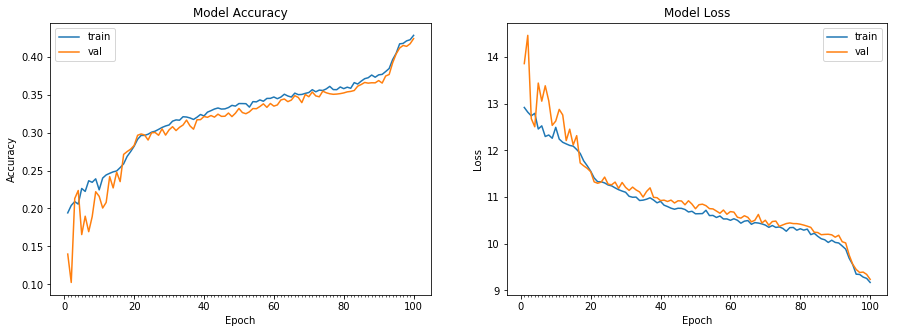

Accuracy on test data is: 42.39


In [9]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)

from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
  return round(0.0075 * 1/(1 + 0.319 * epoch), 10)

# train the model
start = time.time()
# Train the model
my_model_info = my_model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1, callbacks=[LearningRateScheduler(scheduler, verbose=1)])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(my_model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, my_model))